# Example of sequence learning
Implementation of **NLP FROM SCRATCH: GENERATING NAMES WITH A CHARACTER-LEVEL RNN** of *Sean Robertson*. See the tutorial online at this [link](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html) 

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## Concepts
Generating text sequences may be done by recurrently predicting characters (or words) to form language. This is the main goal of a **language model**.

## Data
Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and copy them into a convenient directory.

In [2]:
import os

In [3]:
names_folder = '/Users/flint/Data/names/'
languages, vocabulary = {}, set()
for filename in os.listdir(names_folder):
    with open(os.path.join(names_folder, filename), 'r') as indata:
        lines = [x.rstrip('\n') for x in indata.readlines()]
    languages[filename.replace('.txt', '')] = lines
    for name in lines:
        vocabulary = vocabulary.union(set(name))
labels = list(languages.keys())
vocabulary = sorted(list(vocabulary))
vocabulary.append('EOS') # special char for stop

## Network architecture
The input is given by a one-hot encoding of characters concatenated by the language category and the hidden layer of the previous step (RNN).

![](rnn.png)

see [https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)

In [4]:
import torch
import torch.nn as nn

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(
            len(labels) + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(
            len(labels) + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(
            hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [6]:
def get_data(languages, labels):
    cat = np.random.choice(labels, 1)[0]
    name = np.random.choice(languages[cat], 1)[0]
    return cat, name

> For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

> Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).
    
> The category tensor is a one-hot tensor of size <1 x n_categories>. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

## Vectorize data

In [7]:
# One-hot vector for category
def category_tensor(category, labels):
    li = labels.index(category)
    tensor = torch.zeros(1, len(labels))
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def input_tensor(name, vocabulary):
    tensor = torch.zeros(len(name), 1, len(vocabulary))
    for li in range(len(name)):
        letter = name[li]
        tensor[li][0][vocabulary.index(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def target_tensor(name, vocabulary):
    letter_indexes = [vocabulary.index(name[li]) 
                      for li in range(1, len(name))]
    letter_indexes.append(len(vocabulary) - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [8]:
category_tensor('Italian', labels)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [9]:
it = input_tensor('Ferrara', vocabulary)[:,0,:]
for row in it:
    non_zero_index = int(np.nonzero(row)[0][0])
    print(non_zero_index, '\t', vocabulary[non_zero_index])

12 	 F
37 	 e
50 	 r
50 	 r
33 	 a
50 	 r
33 	 a


In [10]:
tt = target_tensor('Ferrara', vocabulary)
print(tt)
for idx in tt:
    print(idx, '\t', vocabulary[idx])

tensor([37, 50, 50, 33, 50, 33, 87])
tensor(37) 	 e
tensor(50) 	 r
tensor(50) 	 r
tensor(33) 	 a
tensor(50) 	 r
tensor(33) 	 a
tensor(87) 	 EOS


In [11]:
def generate_input(languages, labels, vocabulary):
    lang, name = get_data(languages, labels)
    lang_tensor = category_tensor(lang, labels)
    input_t = input_tensor(name, vocabulary)
    target_t = target_tensor(name, vocabulary)
    return lang_tensor, input_t, target_t

## Train

In [12]:
loss_f = nn.NLLLoss()
learning_rate = 0.0005

def train(rnn, language_tensor, input_name_tensor, target_name_tensor):
    target_name_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_name_tensor.size(0)):
        output, hidden = rnn(
            language_tensor, 
            input_name_tensor[i],
            hidden
        )
        l = loss_f(output, target_name_tensor[i])
        loss += l
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item() / input_name_tensor.size(0)

### Training cycle

In [13]:
import matplotlib.pyplot as plt

In [14]:
rnn = RNN(len(vocabulary), 128, len(vocabulary))
n_iters = 100000
loss_chunk = 200
all_losses = []
run = tqdm(list(range(1, n_iters + 1)))
partial_loss = 0

for i in run:
    output, loss = train(rnn, *generate_input(
        languages, labels, vocabulary))
    partial_loss += loss
    
    if i % loss_chunk == 0:
        all_losses.append(partial_loss / loss_chunk)
        partial_loss = 0

  0%|          | 0/100000 [00:00<?, ?it/s]

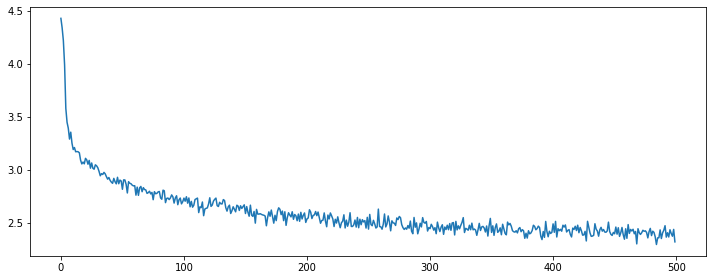

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(all_losses)
plt.tight_layout()
plt.show()

## Sampling

In [16]:
def sample(rnn, language, start_letter, max_len):
    with torch.no_grad():
        lang_t = category_tensor(language, labels)
        input_t = input_tensor(start_letter, vocabulary)
        hidden = rnn.initHidden()
        output_name = start_letter
        for i in range(max_len):
            output, hidden = rnn(lang_t, input_t[0], hidden)
            topv, topi = output.topk(1)
            next_letter = vocabulary[topi[0][0]]
            if next_letter == 'EOS':
                break
            else:
                output_name += next_letter
            input_t = input_tensor(next_letter, vocabulary)
        return output_name

In [20]:
sample(rnn, 'English', 'G', 10)

'Gares'